**Importing necessary libraries**

In [ ]:
# ! pip install tensorfloW

In [ ]:
# Install this package Initially for the BERT model to run.
!pip install tensorflow==2.15.0 tensorflow-text==2.15.0 tensorflow-hub==0.16.1

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import re
import random
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Embedding, Dropout, Input, concatenate, MaxPooling1D, Conv1D
from keras.callbacks import ModelCheckpoint

from xgboost import XGBClassifier

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Reading data from a CSV file**.

In [3]:
# Creating a datframe.
data = pd.read_csv("/content/Combined Data.csv", index_col = 0)
# Displaying 5 random rows from the DataFrame to inspect the data.
data.sample(5)

,statement,status
5586,It's also a problem if the teachers are not fl...,Normal
34517,"People who actually are sick, still have healt...",Anxiety
31593,the point of what?,Normal
6889,No one will know who he is before facing his f...,Normal
27622,"Most of 2017, I stayed at around 135 and have ...",Stress


***Analyzing the data***

Checking the dimensions of the DataFrame (number of rows and columns).

In [4]:
data.shape

(53043, 2)

Calculate the length of each statements.

In [5]:
# Calculate the character length of each statement
data['char_count'] = data['statement'].str.len()

# Display basic statistics of statement lengths
print(data['char_count'].describe())
data.head(5)

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: char_count, dtype: float64


,statement,status,char_count
0,oh my gosh,Anxiety,10.0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64.0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78.0
3,I've shifted my focus to something else but I'...,Anxiety,61.0
4,"I'm restless and restless, it's been a month n...",Anxiety,72.0


***Visualizing the distribution of the lengths of statements.***

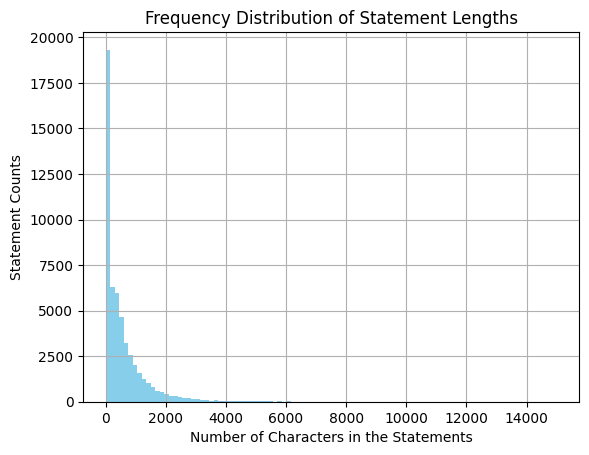

In [6]:
data['char_count'].hist(bins=100, color='skyblue', range=(1,15000))
plt.title('Frequency Distribution of Statement Lengths')
plt.xlabel('Number of Characters in the Statements')
plt.ylabel('Statement Counts')
plt.show()

Filter the data for statements longer than 5000 characters

In [7]:
filtered_df = data[data['char_count']>5000]
filtered_df.count()

,0
statement,222
status,222
char_count,222


Getting the count of statements in each category to understand how diverse the data is.

In [8]:
data['status'].value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


Visualize the count of statements in each category as a bar graph.

<Axes: title={'center': 'Distribution of Sentiments of Different Categories'}, xlabel='status'>

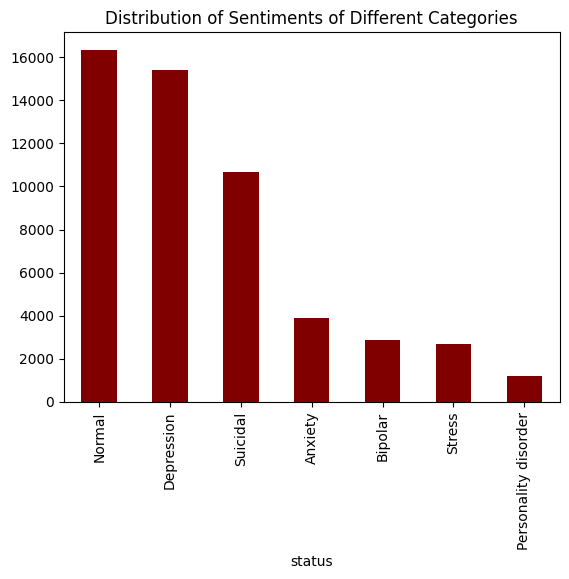

In [9]:
category_count=data['status'].value_counts()
category_count.plot(kind='bar', title='Distribution of Sentiments of Different Categories',
color='#800000')

Creating a pie chart to visualize the distribution of the 'status' column

In [10]:
fig = px.pie(data, names='status',labels='status', title='Mental Health Category Distribution')
fig.show()

**DATA CLEANING AND DATA PRE-PROCESSING**

Checking whether the null values are present in each column of the dataframe.

In [11]:
data.isnull().sum()

,0
statement,362
status,0
char_count,362


Dropping rows with null values from the DataFrame

In [12]:
# removing null values
data.dropna(inplace = True)
data.isna().sum()

,0
statement,0
status,0
char_count,0


Preprocessing the text data by converting statements to lowercase.

In [13]:
data['statement']=data['statement'].str.lower()
data.sample(5)

,statement,status,char_count
15891,i have tried therapy for about 4 months now. t...,Depression,411.0
26053,i feel like i have always been just on the edg...,Depression,788.0
23786,"hello,sometimes i feel like i am having moment...",Depression,1440.0
52218,ear clogging/fullness/dizziness has anyone eve...,Anxiety,291.0
41849,http twitpic com y yi i love you buck,Normal,37.0


Cleaning the data of the 'statement' column based on Regex pattern.

In [14]:
def remove_expression(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
data['statement'] = data['statement'].apply(remove_expression)
data.sample(5)

,statement,status,char_count
48107,something i dont hear talked about a lot is ho...,Depression,279.0
37167,congratulations to our 5 lucky winners ð,Normal,44.0
37457,interesting that i was just asking myself that...,Normal,73.0
20250,i could have had between 50000 250000 if i wa...,Suicidal,729.0
29504,edit complete congrats to username ill pm you ...,Normal,327.0


Tokenizing the statements.

In [15]:
# Apply word_tokenize to each element in the 'statement' column(tokenization)
data['tokens_list'] = data['statement'].apply(word_tokenize)
data.sample(5)

,statement,status,char_count,tokens_list
35791,evening ha into sleepless night around 8pm i h...,Anxiety,853.0,"[evening, ha, into, sleepless, night, around, ..."
48540,always stressed even though i dont have a lot ...,Stress,880.0,"[always, stressed, even, though, i, dont, have..."
32892,did you go swimming,Normal,20.0,"[did, you, go, swimming]"
12300,sohi i am emma a young trans woman from german...,Suicidal,3268.0,"[sohi, i, am, emma, a, young, trans, woman, fr..."
13201,oslim safe weight loss and weight reduction b...,Depression,71.0,"[oslim, safe, weight, loss, and, weight, reduc..."


Removing stopwords and Stemming using Porter stemmer from the tokens

In [16]:
# Stemming
# Initialize the stemmer
stopwords_list = stopwords.words('english')
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens_list(tokens_list):
    return ' '.join(stemmer.stem(str(token)) for token in tokens_list if token not in stopwords_list )

# Apply the function to the 'tokens' column
data['stemmed_tokens'] = data['tokens_list'].apply(stem_tokens_list)

data.sample(5)

,statement,status,char_count,tokens_list,stemmed_tokens
31852,so what are you going to do,Normal,28.0,"[so, what, are, you, going, to, do]",go
28141,i suffer from major depressionanxietyfibromyal...,Stress,417.0,"[i, suffer, from, major, depressionanxietyfibr...",suffer major depressionanxietyfibromyalgia wro...
49649,can hardly afford medication i was recently sw...,Bipolar,273.0,"[can, hardly, afford, medication, i, was, rece...",hardli afford medic recent switch latuda free ...
31756,first you dial seven numbers then ten numbers ...,Normal,70.0,"[first, you, dial, seven, numbers, then, ten, ...",first dial seven number ten number ten number
39905,i feel empty inside miserable and worthless i ...,Depression,311.0,"[i, feel, empty, inside, miserable, and, worth...",feel empti insid miser worthless hate pointles...


Creating WordCloud to identify the important and repeated tokens.

In [ ]:
# Word Cloud
colors = ['#16325B', '#227B94', '#78B7D0', '#FFDC7F', '#18587A', '#11999E', '#283644']

# Define a color function that randomly selects colors from the palette
def color_function(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

Wordcloud for each mental health status category.

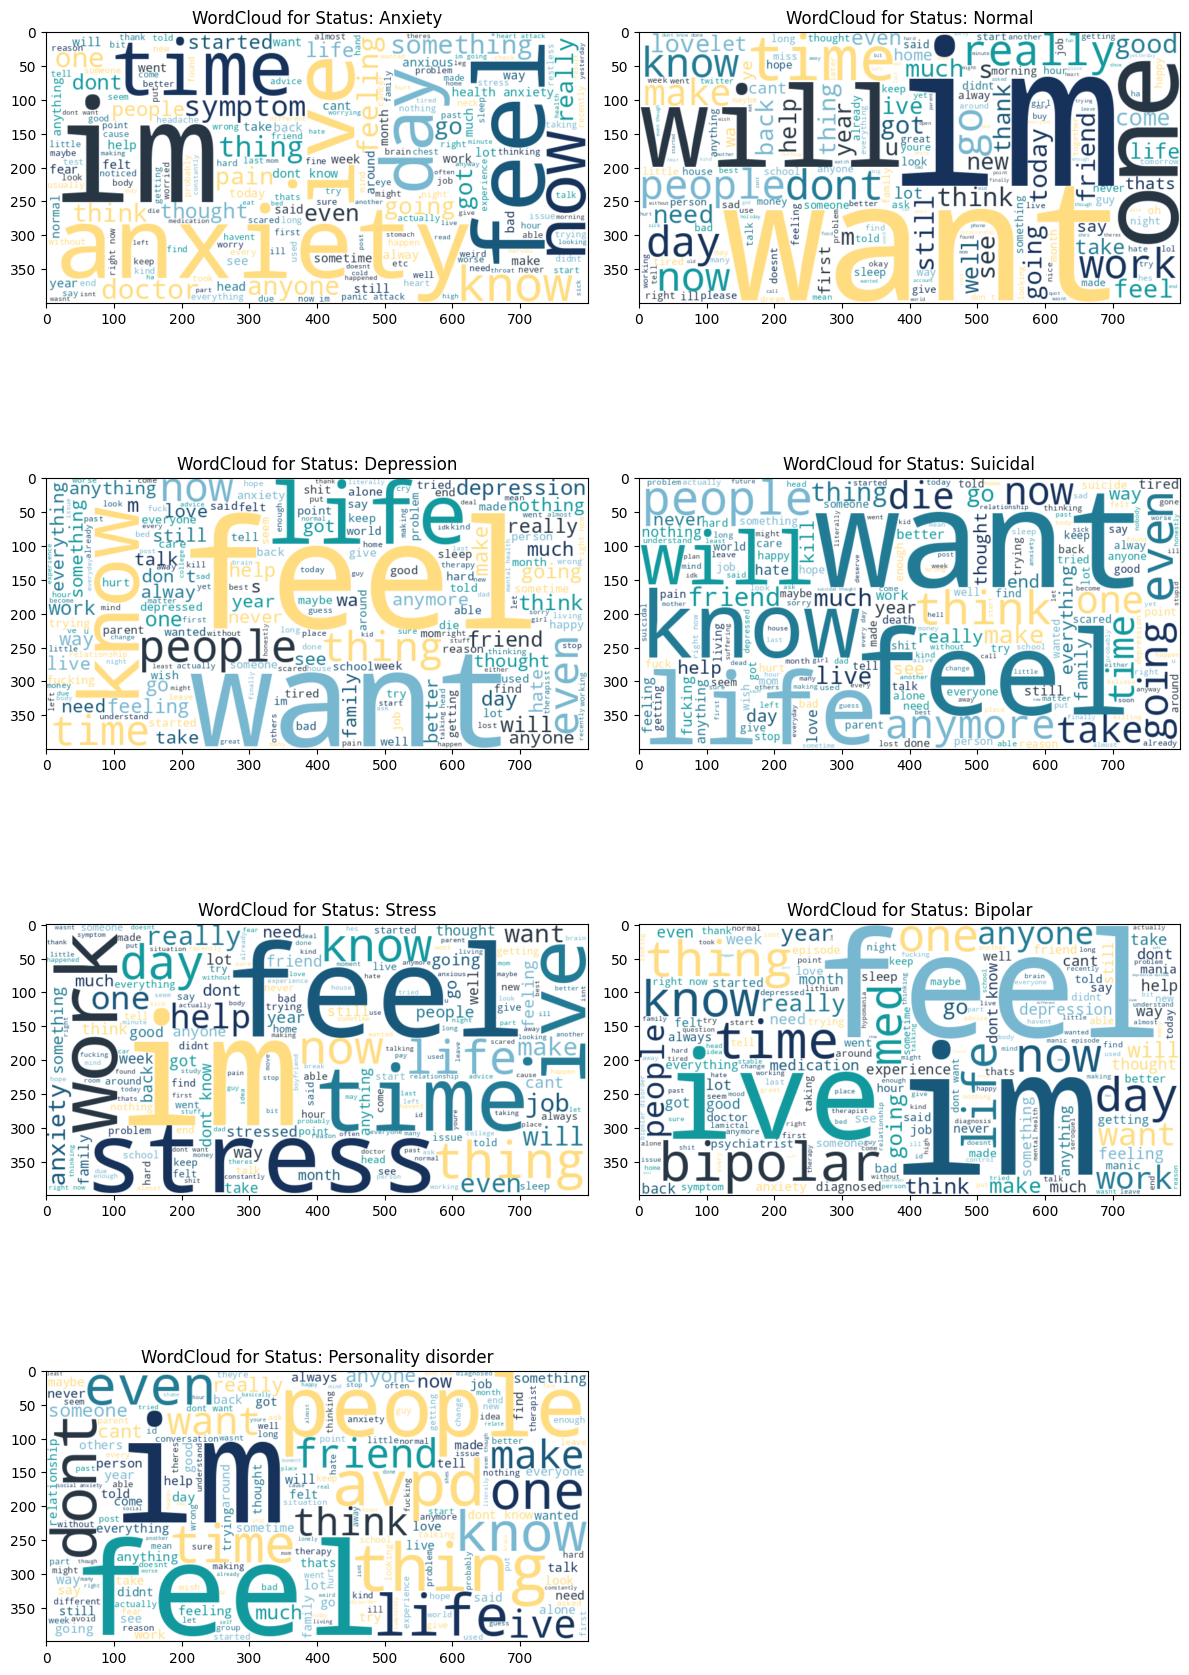

In [ ]:
# Get unique categories in 'status'
categories  = data['status'].unique()

plt.figure(figsize=(12, 36))

# Generate and plot the WordCloud for each category
for i, category  in enumerate(categories):

    # Filter the tokens data for the current status
    total_tokens = ' '.join(data[data['status'] == category]['tokens_list'].dropna().apply(lambda tokens: ' '.join(tokens)).tolist())

    # Generate the WordCloud
    wc = WordCloud(width=800, height=400, background_color='white', color_func=color_function).generate(total_tokens)

    # Plot the WordCloud in a subplot
    axes = plt.subplot(len(categories) // 2 + 1, 2, i + 1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for Status: {category}')

# Apply tight layout after generating all subplots
plt.tight_layout()

# Adjust the vertical spacing between subplots (hspace controls vertical space)
plt.subplots_adjust(hspace= -0.8)
plt.show()

In [17]:
Lb = LabelEncoder()
data['status'] = Lb.fit_transform(data['status'])
print(data['status'].unique())

[0 3 2 6 5 1 4]


In [18]:
row_counts = []

for i in range(7):  # For each status from 0 to 6
    subset = data[data['status'] == i]
    count = len(subset)
    row_counts.append(count)  # Store the count
    print(f"Status {i}: {count} rows")

# Find the maximum value
max_rows = max(row_counts)
print(f"The maximum number of rows is: {max_rows}")


Status 0: 3841 rows
Status 1: 2777 rows
Status 2: 15404 rows
Status 3: 16343 rows
Status 4: 1077 rows
Status 5: 2587 rows
Status 6: 10652 rows
The maximum number of rows is: 16343


In [19]:
from sklearn.utils import resample

# Desired sample size for each group (e.g., equal-sized groups for balancing)
desired_sample_size = max_rows  # Adjust based on your needs

resampled_dfs = []

for i in range(7):  # Status values from 0 to 6
    subset = data[data['status'] == i]

    # Resample each group
    resampled_subset = resample(
        subset,
        replace=True if len(subset) < desired_sample_size else False,  # Use replacement if the group is small
        n_samples=desired_sample_size,  # Resample to desired size
        random_state=42
    )

    resampled_dfs.append(resampled_subset)

# Combine resampled data
data_new = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

# Verify the new distribution
print(data_new['status'].value_counts())


status
0    16343
1    16343
2    16343
3    16343
4    16343
5    16343
6    16343
Name: count, dtype: int64


In [20]:
x = data_new["stemmed_tokens"]
y = data_new["status"]
y.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [21]:
y_encode = to_categorical(y)
y_encode

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [22]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y_encode, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((80080,), (17160,), (17161,), (80080, 7), (17160, 7), (17161, 7))

In [ ]:
x.shape, x_temp.shape

((114401,), (34321,))

In [23]:
tk = Tokenizer()
tk.fit_on_texts(x_train)
vocab_size = len(tk.index_word) + 1
vocab_size

47089

In [24]:
import pickle

# Save the tokenizer used during training
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tk, f)

In [25]:
x_train_number = tk.texts_to_sequences(x_train)
x_val_number = tk.texts_to_sequences(x_val)
x_test_number = tk.texts_to_sequences(x_test)

In [26]:
max_len = 100
x_train_number = pad_sequences(x_train_number, maxlen=max_len, padding="post")
x_test_number = pad_sequences(x_test_number, maxlen=max_len, padding="post")
x_val_number = pad_sequences(x_val_number, maxlen=max_len, padding="post")
x_train_number.shape, x_val_number.shape, x_test_number.shape

((80080, 100), (17160, 100), (17161, 100))

***MULTI CHANNEL CNN MODEL***

In [ ]:
def multi_layer_model(vocab_size, max_length):
    # 1st channel
    inputs1 = Input(shape = (max_length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.7)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)

    # 2nd channel
    inputs2 = Input(shape = (max_length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.7)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)

    # 3rd channel
    inputs3 = Input(shape = (max_length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.7)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)


    merged = concatenate([flat1, flat2, flat3])
    outputs = Dense(7, activation='softmax')(merged)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
filepath="weights_best.keras"
checkpoint = ModelCheckpoint(filepath, monitor= "val_accuracy" , verbose=1, save_best_only=True,mode= "max" )
callbacks_list = [checkpoint]

In [ ]:
model = multi_layer_model(vocab_size=vocab_size, max_length=max_len)
history = model.fit([x_train_number, x_train_number, x_train_number], y_train,
                    validation_data=([x_val_number, x_val_number, x_val_number], y_val),
                    epochs=10,
                    verbose=2,
                    callbacks=callbacks_list)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             4708900   ['input_1[0][0]']             
                                                                                              

In [ ]:
model.load_weights("weights_best.keras")
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
_, acc = model.evaluate([x_train_number, x_train_number, x_train_number], y_train, verbose=0)
print('Training Accuracy: %f' % (acc*100))
# Validation Accuracy
_, acc = model.evaluate([x_val_number, x_val_number, x_val_number], y_val, verbose=0)
print('Validation Accuracy: %f' % (acc*100))
# Test Accuracy
_, acc = model.evaluate([x_test_number, x_test_number, x_test_number], y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Training Accuracy: 99.230766
Validation Accuracy: 93.589741
Test Accuracy: 93.735796


In [ ]:
pred = np.argmax(model.predict([x_test_number, x_test_number, x_test_number]), axis=1)
pred = Lb.inverse_transform(pred)
pred

537/537 [==============================] - 1s 2ms/step


array(['Anxiety', 'Personality disorder', 'Stress', ..., 'Suicidal',
       'Anxiety', 'Depression'], dtype=object)

In [ ]:
history_df = pd.DataFrame()
for key in history.history.keys():
    history_df[key] = history.history[key]
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.603144,0.783616,0.337097,0.899126
1,0.229651,0.921366,0.244793,0.923835
2,0.141945,0.951374,0.238946,0.927098
3,0.111392,0.963124,0.244044,0.930536
4,0.097631,0.968282,0.242974,0.935897
5,0.083169,0.973077,0.274329,0.934033
6,0.081495,0.975075,0.304209,0.932634
7,0.079122,0.977398,0.338193,0.930245
8,0.074704,0.977872,0.361680,0.932168
9,0.070845,0.980195,0.391591,0.931352


In [ ]:
fig = px.line(
    history_df,
    x=history_df.index,
    y=['loss', 'val_loss'],
    title='Model Loss',
    color_discrete_sequence=['green', 'orange']
)
fig.update_xaxes(title_text='Epochs')
fig.update_yaxes(title_text='Loss')
fig.show()


In [ ]:
fig = px.line(
    history_df,
    x=history_df.index,
    y=['accuracy', 'val_accuracy'],
    title='Model Accuracy',
    color_discrete_sequence=['green', 'orange']
)
fig.update_xaxes(title_text='Epochs')
fig.update_yaxes(title_text='Accuracy')
fig.show()


***BERT TRANSFORMER WITH XGBOOST***

In [ ]:
tf.config.run_functions_eagerly(True)
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
print(f"Text input shape: {text_input.shape}, Text input dtype: {text_input.dtype}")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
embedding_model = tf.keras.Model(inputs=[text_input], outputs=[outputs['pooled_output']])

Text input shape: (None,), Text input dtype: <dtype: 'string'>


In [ ]:
train_embeddings = embedding_model.predict(x_train)
val_embeddings = embedding_model.predict(x_val)
test_embeddings = embedding_model.predict(x_test)

537/537 [==============================] - 169s 315ms/step


In [ ]:
# Define the model with parameters
xgb = XGBClassifier(alpha=0.5, lambda_=1.0, learning_rate=0.05, n_estimators=500, early_stopping_rounds=10,eval_metric="logloss")

# Train the model and validate on validation set
xgb.fit(train_embeddings, y_train, eval_set=[(train_embeddings,y_train),(val_embeddings,y_val)], verbose=True)

# Get predictions
y_train_pred = xgb.predict(train_embeddings)
y_val_pred = xgb.predict(val_embeddings)
y_test_pred = xgb.predict(test_embeddings)

# Compute accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Compute log loss
y_train_prob = xgb.predict_proba(train_embeddings)
y_val_prob = xgb.predict_proba(val_embeddings)
y_test_prob = xgb.predict_proba(test_embeddings)

train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_val, y_val_prob)
test_loss = log_loss(y_test, y_test_prob)

# Display the results
print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


[0]	validation_0-logloss:0.40918	validation_1-logloss:0.40964
[1]	validation_0-logloss:0.40048	validation_1-logloss:0.40137
[2]	validation_0-logloss:0.39240	validation_1-logloss:0.39364
[3]	validation_0-logloss:0.38481	validation_1-logloss:0.38640
[4]	validation_0-logloss:0.37769	validation_1-logloss:0.37970
[5]	validation_0-logloss:0.37112	validation_1-logloss:0.37347
[6]	validation_0-logloss:0.36481	validation_1-logloss:0.36759
[7]	validation_0-logloss:0.35877	validation_1-logloss:0.36192
[8]	validation_0-logloss:0.35323	validation_1-logloss:0.35677
[9]	validation_0-logloss:0.34783	validation_1-logloss:0.35178
[10]	validation_0-logloss:0.34274	validation_1-logloss:0.34698
[11]	validation_0-logloss:0.33782	validation_1-logloss:0.34236
[12]	validation_0-logloss:0.33330	validation_1-logloss:0.33813
[13]	validation_0-logloss:0.32878	validation_1-logloss:0.33396
[14]	validation_0-logloss:0.32463	validation_1-logloss:0.33006
[15]	validation_0-logloss:0.32049	validation_1-logloss:0.32622
[1

In [ ]:
# Save the trained XGBoost model
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(Lb, f)

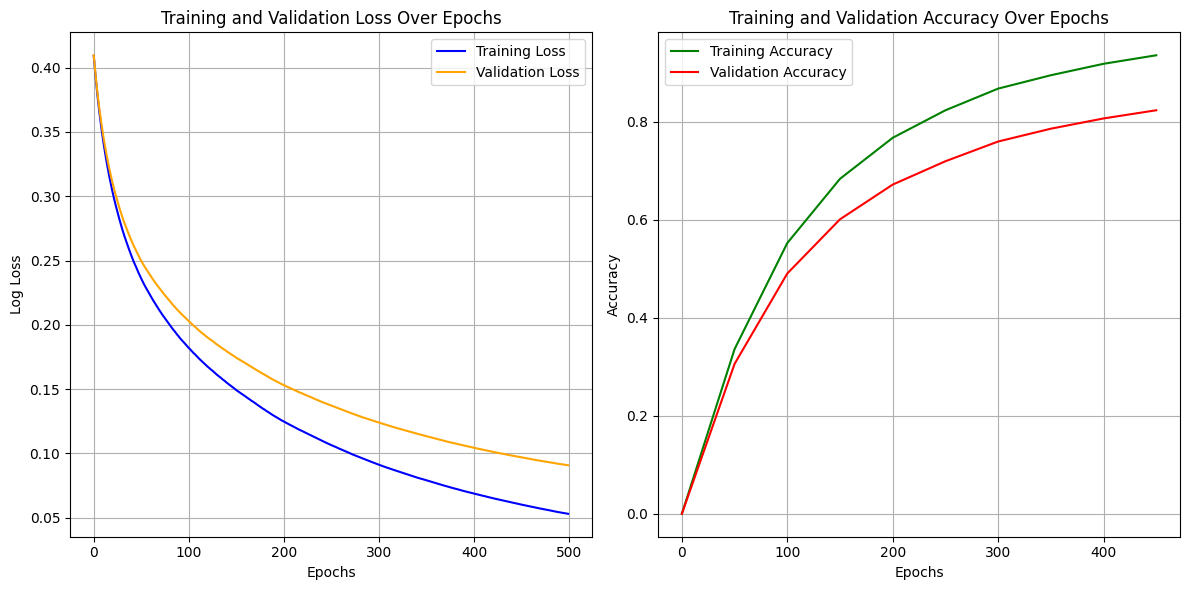

In [ ]:
evals_result = xgb.evals_result()
# Extract the losses for training and validation datasets
training_loss = evals_result['validation_0']['logloss']  # Training loss
validation_loss = evals_result['validation_1']['logloss']  # Validation loss

# Manually calculate accuracy per iteration for training and validation sets
training_accuracy = []
validation_accuracy = []
epochs_to_evaluate = range(0, len(training_loss), 50)  # Sample every 50 epochs

for epoch in epochs_to_evaluate:
    # Predict probabilities at the current stage
    y_train_pred_epoch = xgb.predict(train_embeddings, iteration_range=(0, epoch + 1))
    y_val_pred_epoch = xgb.predict(val_embeddings, iteration_range=(0, epoch + 1))

    # Calculate accuracy for the current epoch
    train_acc = accuracy_score(y_train, y_train_pred_epoch)
    val_acc = accuracy_score(y_val, y_val_pred_epoch)

    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)

# Plot Loss Graph
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(len(training_loss)), training_loss, label="Training Loss", color="blue")
plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_to_evaluate, training_accuracy, label="Training Accuracy", color="green")
plt.plot(epochs_to_evaluate, validation_accuracy, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


***LSTM Model***

In [27]:
from tensorflow.keras.regularizers import l2
num_classes = y_train.shape[1]
# LSTM model with L2 regularization
model_b = Sequential([
    tf.keras.Input(shape=(max_len,)),
    Embedding(input_dim=vocab_size, output_dim=128),
    LSTM(units=32),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))  # L2 regularization
])

# Compile the model
model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

In [28]:
# Fit the model
history_b = model_b.fit(x_train_number, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(x_val_number, y_val))

Epoch 1/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.2692 - loss: 1.8220 - val_accuracy: 0.6990 - val_loss: 0.9325
Epoch 2/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.7396 - loss: 0.8420 - val_accuracy: 0.8306 - val_loss: 0.5852
Epoch 3/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.8687 - loss: 0.4723 - val_accuracy: 0.8832 - val_loss: 0.4431
Epoch 4/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9184 - loss: 0.3491 - val_accuracy: 0.8948 - val_loss: 0.4047
Epoch 5/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9437 - loss: 0.2743 - val_accuracy: 0.9105 - val_loss: 0.3646
Epoch 6/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9608 - loss: 0.2232 - val_accuracy: 0.9107 - val_loss: 0.3688
Epoch 7/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9717 - loss: 0.1938 - val_accuracy: 0.9093 - val_loss: 0.3758
Epoch 8/20
2503/2503 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9767 -

In [ ]:
# Evaluate model_b (LSTM with L2 Regularization)
train_acc_b = model_b.evaluate(x_train_number, y_train, verbose=0)[1]
val_acc_b = model_b.evaluate(x_val_number, y_val, verbose=0)[1]
test_acc_b = model_b.evaluate(x_test_number, y_test, verbose=0)[1]

print("Model B (LSTM with L2 Regularization):")
print(f"  Training Accuracy: {train_acc_b*100:.2f}%")
print(f"  Validation Accuracy: {val_acc_b*100:.2f}%")
print(f"  Test Accuracy: {test_acc_b*100:.2f}%\n")

Model B (LSTM with L2 Regularization):
  Training Accuracy: 99.26%
  Validation Accuracy: 92.18%
  Test Accuracy: 92.90%



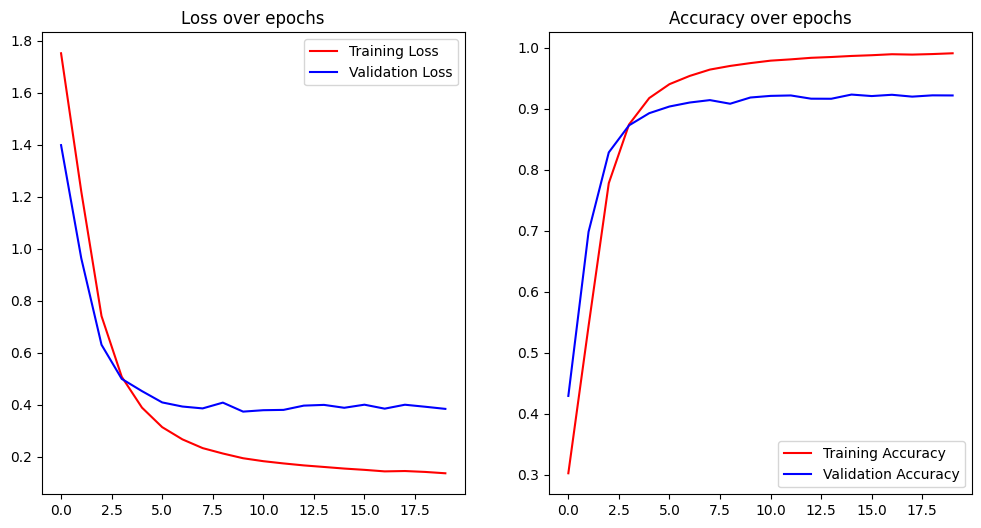

In [ ]:
# Function to display metrics
def display_metrics(history):
    n = len(history.history['loss'])

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(range(n), history.history['loss'], 'r', label='Training Loss')
    ax.plot(range(n), history.history['val_loss'], 'b', label='Validation Loss')
    ax.legend()
    ax.set_title('Loss over epochs')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(n), history.history['accuracy'], 'r', label='Training Accuracy')
    ax.plot(range(n), history.history['val_accuracy'], 'b', label='Validation Accuracy')
    ax.legend(loc='lower right')
    ax.set_title('Accuracy over epochs')

display_metrics(history_b)

***User Input text Class Prediction***

In [ ]:
from ipywidgets import widgets, VBox, Label, Button, Dropdown
from IPython.display import display
import numpy as np
import pickle
import tensorflow_hub as hub
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load resources
# Tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Stopwords and stemmer
stopwords_list = stopwords.words('english')
stemmer = PorterStemmer()

# XGBoost model
with open('xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

# BERT layers
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# BERT embedding model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
embedding_model = tf.keras.Model(inputs=[text_input], outputs=[outputs['pooled_output']])

# Function: Preprocess input text
def preprocess_text(text):
    tokens = text.split()
    stemmed = [stemmer.stem(word) for word in tokens if word.lower() not in stopwords_list]
    return ' '.join(stemmed)

# Function: Generate BERT embeddings
def get_embeddings(text):
    return embedding_model.predict([text])

# IPyWidgets components
input_box = widgets.Text(
    description="Text:",
    placeholder="Enter a sentence",
    style={"description_width": "initial"},
    layout={"width": "600px"}
)

model_selector = Dropdown(
    options=["LSTM", "CNN", "BERT"],
    description="Model:",
    style={"description_width": "initial"},
    layout={"width": "300px"}
)

output_label = widgets.Label(value="")
predict_button = Button(description="Predict", button_style="success")

# Define the prediction logic
def on_predict_clicked(b):
    selected_model = model_selector.value
    input_text = input_box.value.strip()

    if not input_text:
        output_label.value = "Please enter a valid text."
        return

    # Preprocess input text
    processed_text = preprocess_text(input_text)

    if selected_model == "LSTM":
        # LSTM Model: Single-channel input
        input_sequence = tokenizer.texts_to_sequences([processed_text])
        input_padded = pad_sequences(input_sequence, maxlen=max_len, padding='post')
        input_multi_channel = [input_padded]
        prediction = model_b.predict(input_multi_channel)
        predicted_index = np.argmax(prediction, axis=1)

    elif selected_model == "CNN":
        # CNN Model: Multi-channel input
        input_sequence = tokenizer.texts_to_sequences([processed_text])
        input_padded = pad_sequences(input_sequence, maxlen=max_len, padding='post')
        input_multi_channel = [input_padded, input_padded, input_padded]
        prediction = model.predict(input_multi_channel)  # Replace 'model' with the CNN model variable
        predicted_index = np.argmax(prediction, axis=1)

    elif selected_model == "BERT":
        # BERT Model: Generate embeddings and predict with XGBoost
        bert_embedding = get_embeddings(input_text)
        prediction = xgb_model.predict_proba(bert_embedding)
        predicted_index = np.argmax(prediction, axis=1)

    # Map index to category name
    predicted_category = Lb.inverse_transform(predicted_index)  # Replace 'Lb' with the LabelEncoder object
    output_label.value = f"Predicted Category: {predicted_category[0]}"

# Reset output when the user types new text or changes the model
def on_input_change(change):
    output_label.value = ""  # Clear the output

# Attach event handlers
predict_button.on_click(on_predict_clicked)
input_box.observe(on_input_change, names="value")
model_selector.observe(on_input_change, names="value")

# Display the interface
display(VBox([
    Label("Mental Health Text Classification"),
    model_selector,
    input_box,
    predict_button,
    output_label
]))


1/1 [==============================] - 0s 29ms/step


***Cross Validation***

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Assume your data is loaded and preprocessed as x_data and y_data
x_data = x_train_number  # Your input data
y_data = y_train  # Your labels
print(f"x_data size: {len(x_data)}, y_data size: {len(y_data)}")

k = 5  # Number of folds for cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the performance metrics
cnn_accuracies = []
lstm_accuracies = []

fold_number = 1
# Loop through each fold
for train_index, val_index in kf.split(x_data):
    print(f"Running Fold {fold_number}...")
    # Split the data into training and validation sets for this fold
    x_train, x_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # ----- Multi-Channel CNN Model -----
    cnn_model = multi_layer_model(vocab_size=vocab_size, max_length=max_len)  # Adjust with your parameters
    cnn_model.fit([x_train, x_train, x_train], y_train, epochs=5, verbose=0)
    _, cnn_acc = cnn_model.evaluate([x_val, x_val, x_val], y_val, verbose=0)
    cnn_accuracies.append(cnn_acc)
    print(f"Fold {fold_number} - CNN Accuracy: {cnn_acc * 100:.2f}%")

    # ----- LSTM Model -----
    lstm_model = model_b

    # Compile the model
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='accuracy', patience=3, verbose=1, restore_best_weights=True)

    lstm_model.fit(x_train, y_train, epochs=10, verbose=0, callbacks=[early_stopping])
    _, lstm_acc = lstm_model.evaluate(x_val, y_val, verbose=0)
    lstm_accuracies.append(lstm_acc)
    print(f"Fold {fold_number} - LSTM Accuracy: {lstm_acc * 100:.2f}%")

    fold_number += 1

# Calculate average performance metrics
avg_cnn_accuracy = np.mean(cnn_accuracies)
avg_lstm_accuracy = np.mean(lstm_accuracies)

print(f"Average CNN Accuracy: {avg_cnn_accuracy * 100:.2f}%")
print(f"Average LSTM Accuracy: {avg_lstm_accuracy * 100:.2f}%")


x_data size: 80080, y_data size: 80080
Running Fold 1...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 100)             4708900   ['input_2[0][0]']             
                                     

***Hypothesis Testing***

In [ ]:
from scipy.stats import ttest_rel

# Perform a paired t-test
t_stat, p_value = ttest_rel(cnn_accuracies, lstm_accuracies)

print("\nHypothesis Testing Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the models.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the models.")



Hypothesis Testing Results:
T-statistic: -2.4131
P-value: 0.0733
Fail to reject the null hypothesis: There is no significant difference between the models.
